In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.linalg import cholesky
from sklearn.metrics.cluster import normalized_mutual_info_score
from networkx.algorithms.community import greedy_modularity_communities
import cvxpy
import pandas as pd
import os
from networkx.algorithms.community import kernighan_lin_bisection
from numpy import linalg as LA

In [ ]:
!pip install scipy==1.8.0
!pip list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 14.0 MB/s eta 0:00:00


In [ ]:
colors = ['red', 'blue', 'green', 'yellow', 'pink', 'crimson', 'orange']

np.set_printoptions(threshold=np.inf)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## 提案手法

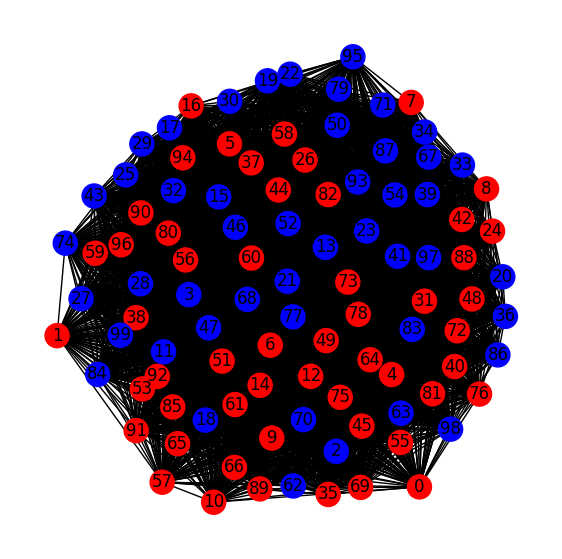

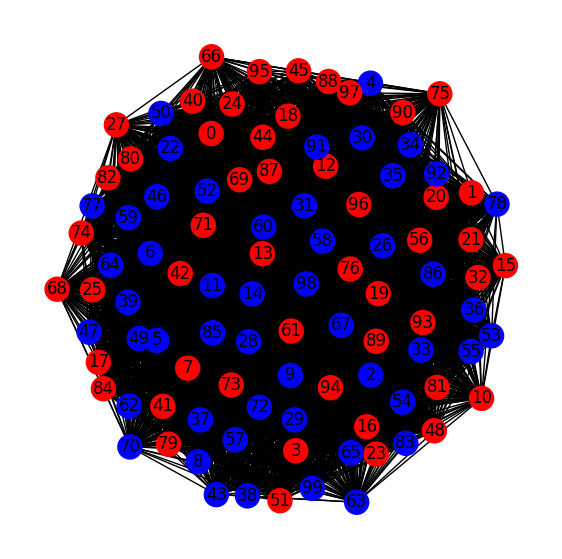

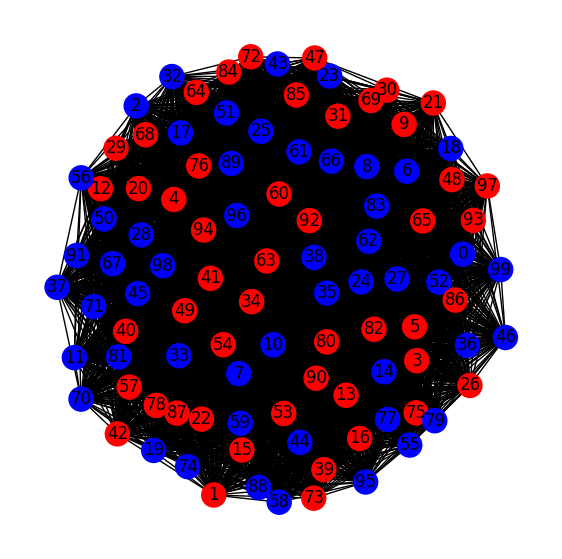

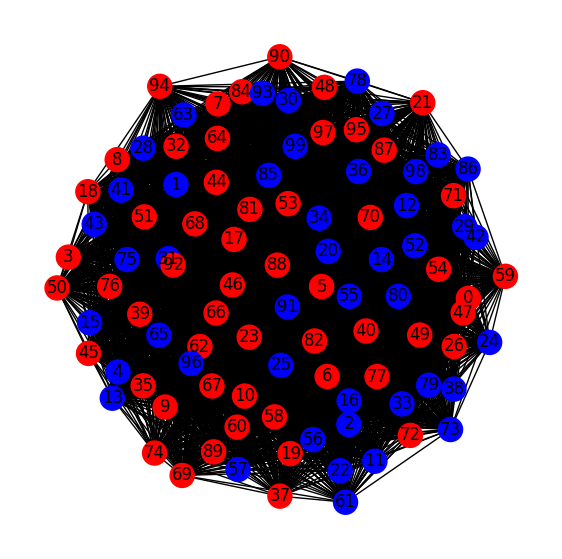

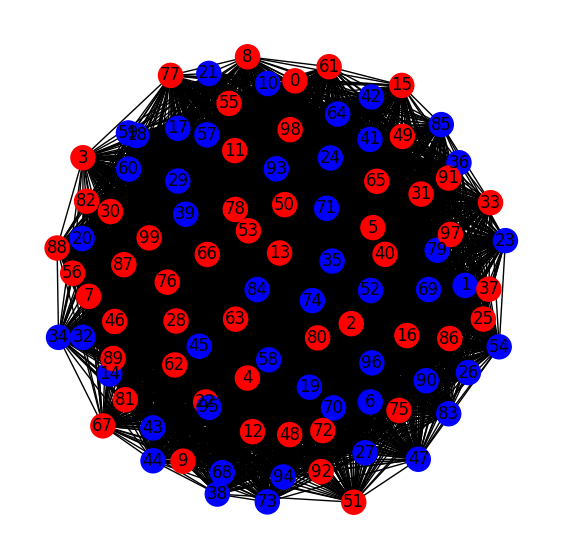

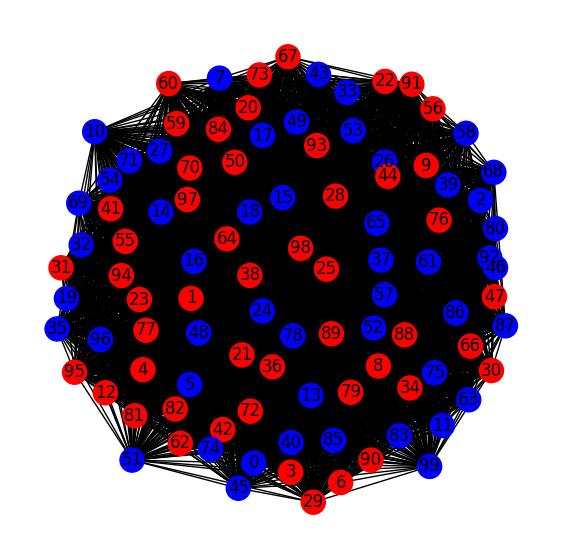

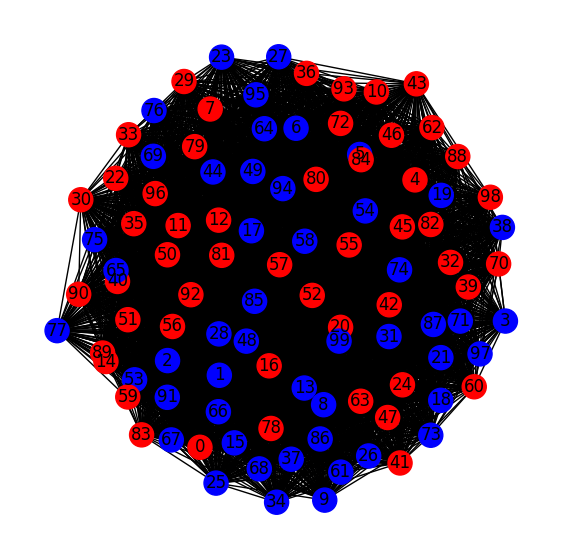

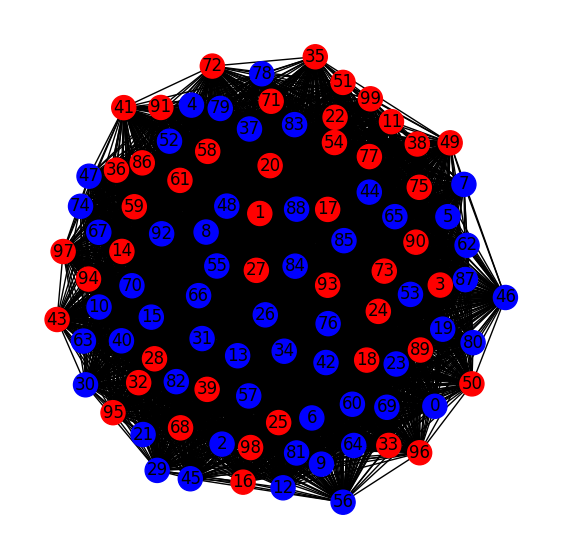

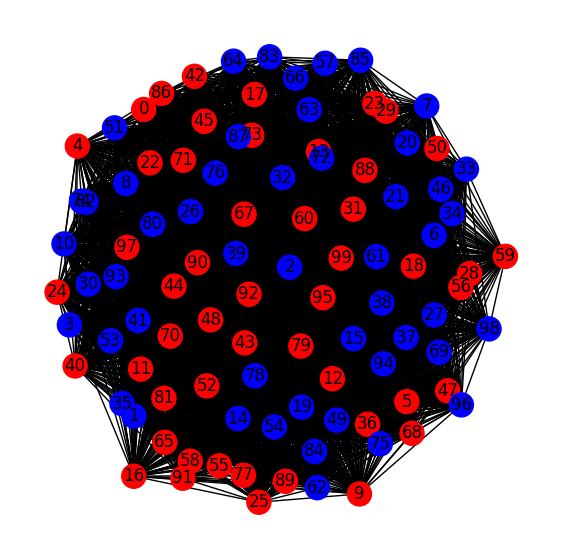

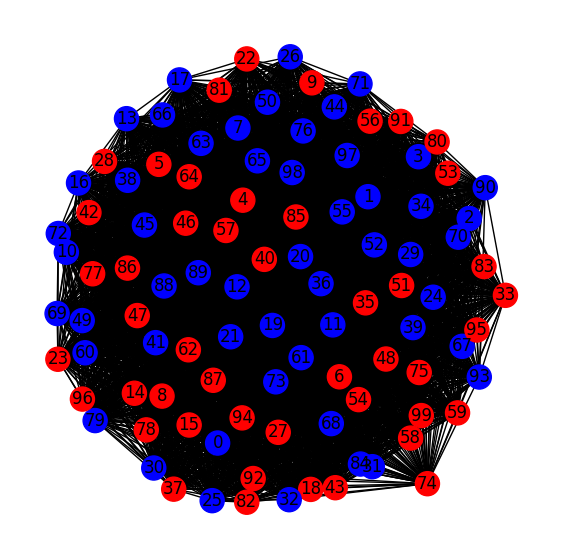

0.0031971440298205396


In [ ]:
mean = 0

for i in range(10):
  G = nx.planted_partition_graph(2, 50, 0.8, 0.9, seed=i)
  pos = nx.spring_layout(G)

  N = G.number_of_nodes()
  M = G.number_of_edges()
  Np = 0
  Nn = 0
  c = 3
  A = np.array(nx.adjacency_matrix(G).todense())
  k = np.sum(A, axis=0)
  #モジュラリティ行列B
  B = np.array([[A[i, j] - ((k[i] * k[j]) / (2 * M))  for j in range(N)] for i in range(N)])
  #モジュラリティ行列 B の固有値,固有ベクトルを求める
  values, vectors = np.linalg.eig(B)
  vectors = np.array([[vectors[i][j].real for j in range(N)]for i in range(N)])
  vectors = np.array([[0 if abs(vectors[i][j]) < 1e-10 else vectors[i][j]  for j in range(N)]for i in range(N)])
  values = np.array([0 if abs(i) < 1e-10 else i for i in values])
  vectors = vectors.T
  z = list(zip(values, vectors))
  for i in values:
    if i < 0:
      Nn = Nn + 1
    if i > 0:
      Np = Np + 1
  c = 1
  #固有値の昇順に並べ替える
  z = sorted(z, key=lambda x :x[0])  
  values = [z[i][0] for i in range(len(z))]
  vectors = np.array([list(z[i][1]) for i in range(N)])
  Vp = np.array([list(z[i][1]) if z[i][0] > 0 else list(np.zeros(N)) for i in range(N-Np, N)]).T
  Vn = np.array([list(z[i][1]) if z[i][0] < 0 else list(np.zeros(N)) for i in range(Nn)]).T 
  V = vectors.T
  Lam = np.array([[values[i] if i == j else 0 for j in  range(N)] for i in range(N)])
  Lamp = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] > 0) else 0 for j in  range(N-Np, N)] for i in range(N-Np, N)])
  Lamn = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] < 0) else 0 for j in  range(Nn)] for i in range(Nn)])


  lam_1 = 0.1
  lam_2 = 0.1
  xk = np.ones((Np, 1))
  #変数定義
  s = cvxpy.Variable((N, 1))
  x = cvxpy.Variable((Np, 1))
  y = cvxpy.Variable((Nn, 1)) 
  #問題定義
  for i in range(50):
    obj = 0
    obj += xk.T @ Lamp @ (x - xk) + xk.T @ Lamp @ xk
    #obj += cvxpy.quad_form(y, Lamn)  #yT*Λn*y
    #obj -= lam_1 * cvxpy.norm(s-1, p=1)
    #obj -= lam_2 * cvxpy.norm(s+1, p=1)
    obj = cvxpy.Maximize(obj)
    constraints = [x == Vp.T @ s,  -1 <= s , s<= 1]
    prob = cvxpy.Problem(obj, constraints)
    result = prob.solve()
    xk = x.value
    #結果表示
    #print('obj:', prob.value)
    #print('s:', s.value)
    s_value = s.value.reshape(N)
    #print(s_value)
 
  group_1 = [i for i in range(G.number_of_nodes()) if s_value[i]>0]
  group_2 = [i for i in range(G.number_of_nodes()) if s_value[i]<0]
  s_label = np.zeros(N)
  for i in range(N):
    for j in group_1:
      if j == i:
        s_label[i] =  1
    for j in group_2:
      if j == i:
        s_label[i] =  -1

  #グラフの可視化
  partition = [group_1, group_2]
  color_map = ['black'] * nx.number_of_nodes(G)
  counter = 0
  for c in partition :
    for n in c :
      color_map[n] = colors[counter]
    counter = counter + 1
  nx.draw_networkx_edges(G, pos)
  nx.draw_networkx_nodes(G, pos, node_color=color_map)
  nx.draw_networkx_labels(G, pos)
  plt.axis('off')
  plt.rcParams['figure.figsize'] = (7 ,7)
  plt.show()

  pos = nx.spring_layout(G)
  best_label = [1 if G.nodes[i]["block"]== 0 else -1 for i in G.nodes()]

  nmi = normalized_mutual_info_score(best_label, s_label)
  mean += nmi

mean = mean / 10
print(mean)

## CNM法

In [ ]:
mean = 0

for i in range(100):
  G = nx.planted_partition_graph(2, 50, 0.8, 0.1, seed=i)
  pos = nx.spring_layout(G)

  N = G.number_of_nodes()
  M = G.number_of_edges()
  lst_m = greedy_modularity_communities(G, resolution=0.95)

  #モジュラリティ最適化の関数を用いるときに使う
  s = np.zeros(N)
  counter=0
  for c in lst_m :
    for n in c :
      if counter==0:
        s[n] = 1
      if counter==1:
        s[n] = -1
    counter = counter + 1
  print('s:', s)

  pos = nx.spring_layout(G)
  best_label = [1 if G.nodes[i]["block"]== 0 else -1 for i in G.nodes()]

  nmi = normalized_mutual_info_score(best_label, s)
  mean += nmi

mean = mean / 100
print(mean)

s: [-1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
s: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
s: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1

## kernighan lin bisection

In [ ]:
mean = 0

for i in range(100):
  G = nx.planted_partition_graph(2, 50, 0.8, 0.1, seed=i)
  pos = nx.spring_layout(G)

  N = G.number_of_nodes()
  M = G.number_of_edges()
  lst_b = kernighan_lin_bisection(G)
  s = np.zeros(N)
  counter=0
  for c in lst_b :
    for n in c :
      if counter==0:
        s[n] = 1
      if counter==1:
        s[n] = -1
    counter = counter + 1
  print('s:', s)

  pos = nx.spring_layout(G)
  best_label = [1 if G.nodes[i]["block"]== 0 else -1 for i in G.nodes()]

  nmi = normalized_mutual_info_score(best_label, s)
  mean += nmi

mean = mean / 100
print(mean)

## スペクトラルなモジュラリティ最適化

In [ ]:
mean = 0

for i in range(100):
  G = nx.planted_partition_graph(2, 10, 0.8, 0.6, seed=i)
  pos = nx.spring_layout(G)

  N = G.number_of_nodes()
  M = G.number_of_edges()
  A = np.array(nx.adjacency_matrix(G).todense())
  k = np.sum(A, axis=0)
  #モジュラリティ行列B
  B = np.array([[A[i, j] - ((k[i] * k[j]) / (2 * M))  for j in range(N)] for i in range(N)])
  #モジュラリティ行列 B の固有値,固有ベクトルを求める
  values, vectors = np.linalg.eig(B)
  vectors = vectors.T
  z = list(zip(values, vectors))
  #固有値の昇順に並べ替える
  z = sorted(z, key=lambda x :x[0])  
  v_max = z[-1][1]
  s = np.zeros(N)
  for i in range(len(v_max)):
    if v_max[i] < 0:
      s[i] = -1
    if v_max[i] >= 0:
      s[i] = 1
  print(s)
  group1 = []
  group2 = []
  for i in range(len(s)):
    if s[i] == -1:
      group1.append(i)
    if s[i] == 1:
      group2.append(i)
  lst_m = [group1, group2]
  print('ネットワーク分割結果：')
  print(lst_m)

  pos = nx.spring_layout(G)
  best_label = [1 if G.nodes[i]["block"]== 0 else -1 for i in G.nodes()]

  nmi = normalized_mutual_info_score(best_label, s)
  mean += nmi

mean = mean / 100
print(mean)

In [ ]:
l =0.1
while l < 100:
  mean = 0

  for i in range(100):
    G = nx.planted_partition_graph(2, 50, 0.8, 0.5, seed=i)
    pos = nx.spring_layout(G)

    N = G.number_of_nodes()
    M = G.number_of_edges()
    V = np.zeros((N, N))
    Vp = np.zeros((N, N))
    Vn = np.zeros((N, N))
    Lam = np.zeros((N, N))
    Lamp = np.zeros((N, N))
    Lamn = np.zeros((N, N))
    Np = 0
    Nn = 0
    A = np.array(nx.adjacency_matrix(G).todense())
    k = np.sum(A, axis=0)
    #モジュラリティ行列B
    B = np.array([[A[i, j] - ((k[i] * k[j]) / (2 * M))  for j in range(N)] for i in range(N)])
    #モジュラリティ行列 B の固有値,固有ベクトルを求める
    values, vectors = np.linalg.eig(B)
    values = np.array([i.real for i in values])
    vectors = np.array([[vectors[i][j].real for j in range(N)]for i in range(N)])
    #vectors = np.array([[0 if abs(vectors[i][j]) < 1e-5 else vectors[i][j]  for j in range(N)]for i in range(N)])
    values = np.array([0 if abs(i) < 1e-5 else i for i in values])
    vectors = vectors.T
    z = list(zip(values, vectors))
    for i in values:
      if i < 0:
        Nn = Nn + 1
      if i > 0:
        Np = Np + 1
    #固有値の昇順に並べ替える
    z = sorted(z, key=lambda x :x[0])  
    values = [z[i][0] for i in range(len(z))]
    vectors = np.array([list(z[i][1]) for i in range(N)])
    Vp = np.array([list(z[i][1]) if z[i][0] > 0 else list(np.zeros(N)) for i in range(N-Np, N)]).T
    Vn = np.array([list(z[i][1]) if z[i][0] < 0 else list(np.zeros(N)) for i in range(Nn)]).T
    V = vectors.T
    Lam = np.array([[values[i] if i == j else 0 for j in  range(N)] for i in range(N)])
    Lamp = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] > 0) else 0 for j in  range(N-Np, N)] for i in range(N-Np, N)])
    Lamn = np.array([[Lam[i][j]**2 if (i == j) & (Lam[i][j] < 0) else 0 for j in  range(Nn)] for i in range(Nn)])
  
    Bp = Vp @ Lamp @ Vp.T
    Bn = Vn @ Lamn @ Vn.T
  
    lam_1 = l
    lam_2 = l
    xk = np.zeros((Np, 1))
    yk = np.zeros((Nn, 1))
    #変数定義
    s = cvxpy.Variable((N, 1))
    x = cvxpy.Variable((Np, 1))
    y = cvxpy.Variable((Nn, 1))
    #問題定義
    for i in range(30):
      obj = 0
      obj += xk.T @ Lamp @ (x - xk) + xk.T @ Lamp @ xk
      obj -= yk.T @ Lamn @ (y - yk) + yk.T @ Lamn @ yk
      #obj -= cvxpy.quad_form(y, Lamn)  #yT*Λn*y
      obj -= lam_1 * cvxpy.norm(s-1, p=1)
      obj -= lam_2 * cvxpy.norm(s+1, p=1)
      obj = cvxpy.Maximize(obj)
      constraints = [x == Vp.T @ s , y == Vn.T @ s ,-1 <= s , s<= 1]

      prob = cvxpy.Problem(obj, constraints)
      result = prob.solve()
      xk = x.value
      #結果表示
      s_value = s.value.reshape(N)
    
    group_1 = [i for i in range(G.number_of_nodes()) if s_value[i]>0]
    group_2 = [i for i in range(G.number_of_nodes()) if s_value[i]<0]
    s_label = np.zeros(N)
    for i in range(N):
      for j in group_1:
        if j == i:
          s_label[i] =  1
      for j in group_2:
        if j == i:
          s_label[i] =  -1

    pos = nx.spring_layout(G)
    best_label = [1 if G.nodes[i]["block"]== 0 else -1 for i in G.nodes()]

    nmi = normalized_mutual_info_score(best_label, s_label)
    mean += nmi

  mean = mean / 100
  print(mean)
  l += 0.1

0.9971650089541962
0.9971650089541965
0.9971650089541965
0.9971650089541962
0.9978737567156473
0.9971650089541962
0.9964562611927456
0.9978737567156473
0.9964562611927456
0.9985825044770982
0.9971650089541962
0.9978737567156473
0.9985825044770982
0.9936212701469418
0.9978737567156473
0.9971650089541962
0.9964562611927456
0.9957475134312945
0.9971650089541965
0.9964562611927456
0.9964562611927456
0.9957475134312945
0.9971650089541962
0.9985825044770982
0.9978737567156473
0.9978737567156473
0.9985825044770982
0.9985825044770982
0.9978737567156473
0.9971650089541965
0.9978737567156473
0.9985825044770982
0.9985825044770982
0.9978737567156473
0.9985825044770982
0.9985825044770982
0.9978737567156473
0.9978737567156473
0.9971650089541962
0.9978737567156473
0.9985825044770982
0.9978737567156473
0.9985825044770982
0.9964562611927456
0.9964562611927456
0.9957475134312945
0.9971650089541965
0.9985825044770982
0.9971650089541965
0.9964562611927456
0.9964562611927456
0.9964562611927456
0.9978737567